In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_onlychild = processed_data[processed_data['are_you_an_only_child'].isin([0, 1])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_onlychild['rating'] = df_onlychild['rating'].astype(str)


# only keep spcific columns
df_onlychild = df_onlychild[['movie_name', 'year', 'rating', 'are_you_an_only_child']]

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



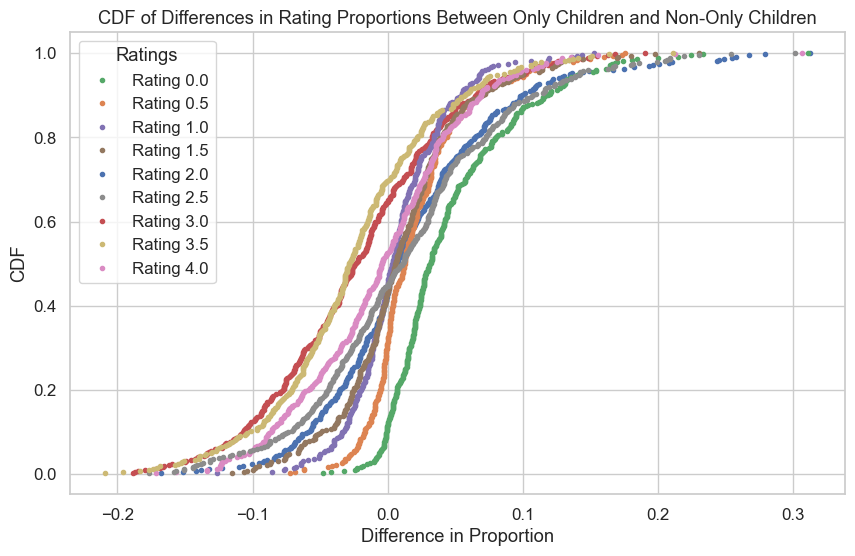

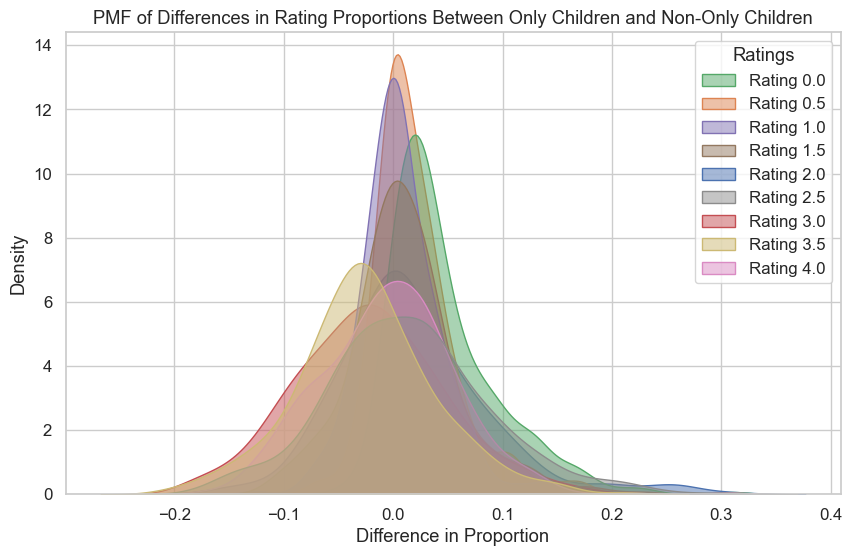

In [25]:
grouped = df_onlychild.groupby(['movie_name', 'year', 'are_you_an_only_child'])['rating'].value_counts(normalize=True).rename('proportion').reset_index()

# difference between only child and non-only child for each movie
only_child_group = grouped[grouped['are_you_an_only_child'] == 1]
non_only_child_group = grouped[grouped['are_you_an_only_child'] == 0]

merged = pd.merge(only_child_group, non_only_child_group, on=['movie_name', 'year', 'rating'], suffixes=('_only_child', '_non_only_child'))
merged['difference'] = merged['proportion_only_child'] - merged['proportion_non_only_child']
merged = merged.sort_values(by='difference', key=abs, ascending=True).drop(columns=['are_you_an_only_child_only_child', 'are_you_an_only_child_non_only_child'])

# plot the differences for each rating
# CDF plot for the differences

plt.figure(figsize=(10, 6))
for rating in merged['rating'].unique():
    subset = merged[merged['rating'] == rating]
    sorted_diff = np.sort(subset['difference'])
    cdf = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff)
    plt.plot(sorted_diff, cdf, marker='.', linestyle='none', label=f'Rating {rating}')

plt.xlabel('Difference in Proportion')
plt.ylabel('CDF')

# order the legend by rating
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(handles, labels, title='Ratings')
plt.title('CDF of Differences in Rating Proportions Between Only Children and Non-Only Children')
plt.show()


# plot a PMF plot for the differences
plt.figure(figsize=(10, 6))
for rating in merged['rating'].unique():
    subset = merged[merged['rating'] == rating]
    sns.kdeplot(subset['difference'], label=f'Rating {rating}', fill=True, alpha=0.5)
plt.xlabel('Difference in Proportion')
plt.ylabel('Density')
# order the legend by rating
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(handles, labels, title='Ratings')
plt.title('PMF of Differences in Rating Proportions Between Only Children and Non-Only Children')
plt.show()

In [9]:
def total_variation_distance(p, q):
    p, q = np.asarray(p, dtype=float), np.asarray(q, dtype=float)
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * np.sum(np.abs(p - q))


df_gender_movie = df_onlychild.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['chi_p_value', 'dof', 'expected', 'jvd', 'mw_p_value', 'mw_u_stat'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()

    # Split ratings by only child status
    only_child_ratings = ratings[group['are_you_an_only_child'] == 1].astype(float)
    not_only_child_ratings = ratings[group['are_you_an_only_child'] == 0].astype(float)

    if len(only_child_ratings) > 0 and len(not_only_child_ratings) > 0:

        # check if ratings have na values
        if only_child_ratings.isna().sum() > 0 or not_only_child_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(only_child_ratings, not_only_child_ratings, alternative='two-sided')
        
        # x^2 test
        contingency_table = pd.crosstab(group['are_you_an_only_child'], group['rating'])
        chi2, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

        only_child = contingency_table.loc[1]
        not_only_child = contingency_table.loc[0]
        results.loc[movie_name] = [p_value_chi2, dof, expected, total_variation_distance(only_child, not_only_child), p_value_mw, u_stat]